In [1]:
!mkdir /home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/model_final/Usleep/outputs

In [2]:
# !pip install mne==1.4.0

In [3]:
OUTPUT_FOLDER='/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/model_final/Usleep/outputs'

In [4]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## data_utils

In [5]:
import mne

## runner_utils

In [6]:
import os
import torch
import random
import numpy as np

def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## dataset

In [7]:
def add_noise(data):
    if np.random.rand() > 0.5:
        data += np.random.normal(0, 0.01, (data.shape))
    return data

def handle_mixup(idx, data, label, mixup_data, supervised_mixup_data, mixup_idx, mixup_rate):
    mixup_data = mixup_data
    # use supervised mixup data if available
    if supervised_mixup_data is not None:
        mixup_data = supervised_mixup_data[label]
    # if mixup condition is set and id is not mixable
    if mixup_idx is not None and not mixup_idx[idx]:
        mixup_data = None
    # do mixup if available
    if mixup_data is not None:
        data = mixup(data, mixup_data, mixup_rate)
    
    return data

def mixup(data, mixup_data, mixup_rate):
    mixup_rate = np.random.rand() * mixup_rate
    idx = np.random.randint(0, len(mixup_data))
    return (1-mixup_rate)*data + mixup_rate*mixup_data[idx]

In [8]:
class SleepDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None, mixup_data=None, supervised_mixup_data=None, mixup_idx=None, mixup_rate=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
        self.supervised_mixup_data = supervised_mixup_data
        self.mixup_data = mixup_data
        self.mixup_idx = mixup_idx
        self.mixup_rate = mixup_rate

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]

        if self.labels is not None:
            label = self.labels[idx].astype(np.int64)
        else:
            label = -1
        
        ### DATA AUGMENTATION ###
        data = handle_mixup(idx, data, label, self.mixup_data, self.supervised_mixup_data, self.mixup_idx, self.mixup_rate)

        if self.transform:
            data = self.transform(data)
        ### END DATA AUGMENTATION ###

        data = data.astype(np.float32)

        return {"eeg": data, "label": label}

## runner

### Focal loss

In [9]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    """ Focal loss with optional label smoothing.

    Calculates mean focal loss over given data with optional label smoothing.

    Attributes
    ----------
        alpha: int = 1
        gamma: int = 2
        logits: bool = True
        reduce: bool = True
        ls: float = None
            label smoothing ratio, if None label smoothing will not be applied
        classes: int = None
            number of classes required for label smoothing
    """

    def __init__(
        self,
        alpha: int = 1,
        gamma: int = 2,
        logits: bool = True,
        reduce: bool = True,
        ls: float = 0.05,
        classes: int = 6,
    ):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        self.ls = ls
        self.classes = classes

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=6)

        if self.ls is not None:
            targets = (1 - self.ls) * targets + self.ls / self.classes

        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### VAT

In [10]:
# implementation from: https://github.com/lyakaap/VAT-pytorch

import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F


@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d


class VATLoss(nn.Module):

    def __init__(self, xi=10.0, eps=1.0, ip=1):
        """VAT loss
        :param xi: hyperparameter of VAT (default: 10.0)
        :param eps: hyperparameter of VAT (default: 1.0)
        :param ip: iteration times of computing adv noise (default: 1)
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip

    def forward(self, model, x):
        with torch.no_grad():
            pred = F.softmax(model(x), dim=1)

        # prepare random unit tensor
        d = torch.rand(x.shape).sub(0.5).to(x.device)
        d = _l2_normalize(d)

        with _disable_tracking_bn_stats(model):
            # calc adversarial direction
            for _ in range(self.ip):
                d.requires_grad_()
                pred_hat = model(x + self.xi * d)
                logp_hat = F.log_softmax(pred_hat, dim=1)
                adv_distance = F.kl_div(logp_hat, pred, reduction='batchmean')
                adv_distance.backward()
                d = _l2_normalize(d.grad)
                model.zero_grad()
    
            # calc LDS
            r_adv = d * self.eps
            pred_hat = model(x + r_adv)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            lds = F.kl_div(logp_hat, pred, reduction='batchmean')

        return lds

### train, validate, predict

In [11]:
import torch
import numpy as np

def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = []
    targets_all = []
    outputs_all = []

    vat_loss = VATLoss(xi=10.0, eps=1.0, ip=1)

    model.train()
    t = tqdm(loader)

    for i, sample in enumerate(t):
        optimizer.zero_grad()

        eeg = sample["eeg"].to(args.device)
        target = sample["label"].to(args.device)

        lds = vat_loss(model, eeg)
        output = model(eeg)
        loss = criterion(output, target) + args.alpha * lds
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        losses.append(loss.item())
        
        target = target.cpu().numpy()
        output = output.detach().cpu().numpy()

        targets_all.extend(target)
        outputs_all.extend(output)

        output_loss = np.mean(losses)
        output_score = np.mean(targets_all == np.argmax(outputs_all, axis=1))

        t.set_description(
            f"Epoch {epoch}/{args.epochs} - Train loss: {output_loss:0.4f}, score: {output_score:0.4f}"
        )

    return targets_all, outputs_all, output_score, output_loss


def validate(args, model, loader, criterion, desc="Valid"):
    losses = []
    targets_all = []
    outputs_all = []

    t = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(t):
            eeg = sample["eeg"].to(args.device)
            target = sample["label"].to(args.device)

            output = model(eeg)
            loss = criterion(output, target)

            losses.append(loss.item())
            targets_all.extend(target.cpu().numpy())
            outputs_all.extend(output.detach().cpu().numpy())

            output_loss = np.mean(losses)
            output_score = np.mean(targets_all == np.argmax(outputs_all, axis=1))

            t.set_description(
                f"\t  - {desc} loss: {output_loss:0.4f}, score: {output_score:0.4f}"
            )

    return targets_all, outputs_all, output_score, output_loss


def predict(args, model, loader):
    outputs_all = []

    t = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(t):
            eeg = sample["eeg"].to(args.device)

            output = model(eeg)
            outputs_all.extend(output.detach().cpu().numpy())
    return outputs_all

## model

In [12]:
import torch
import torch.nn as nn

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from braindecode.models import USleep

def get_linear(in_features, out_features):
    return nn.utils.weight_norm(nn.Linear(in_features, out_features))

class BaseEEGClassifier(nn.Module):
    def __init__(self, n_chans=2, sfreq=100, depth=6, n_time_filters=5, 
                 complexity_factor=1.67, with_skip_connection=True, n_outputs=5, 
                 input_window_seconds=30, time_conv_size_s=9 / 128, ensure_odd_conv_size=True):
        super(BaseEEGClassifier, self).__init__()
        
        self.usleep = USleep(
            n_chans=n_chans,
            sfreq=sfreq,
            depth=depth,
            n_time_filters=n_time_filters,
            complexity_factor=complexity_factor,
            with_skip_connection=with_skip_connection,
            n_outputs=n_outputs,
            input_window_seconds=input_window_seconds,
            time_conv_size_s=time_conv_size_s,
            ensure_odd_conv_size=ensure_odd_conv_size
        )

    def forward(self, x):
        x = self.usleep(x)
        return x

class EEGClassifier(nn.Module):
    def __init__(self):
        super(EEGClassifier, self).__init__()

        self.base = BaseEEGClassifier()
        self.fc = get_linear(5, 6)  # Adjust based on USleep output features

    def features(self, x):
        x = self.base(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

# Example usage
model = EEGClassifier()
print(model)


EEGClassifier(
  (base): BaseEEGClassifier(
    (usleep): USleep(
      (encoder): Sequential(
        (0): _EncoderBlock(
          (block_prepool): Sequential(
            (0): Conv1d(2, 6, kernel_size=(7,), stride=(1,), padding=same)
            (1): ELU(alpha=1.0)
            (2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (pad): ConstantPad1d(padding=(1, 1), value=0)
          (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): _EncoderBlock(
          (block_prepool): Sequential(
            (0): Conv1d(6, 9, kernel_size=(7,), stride=(1,), padding=same)
            (1): ELU(alpha=1.0)
            (2): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (pad): ConstantPad1d(padding=(1, 1), value=0)
          (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): _Enc

/home/deepak/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [14]:
import seaborn as sns
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix

### args

In [15]:
import json

class base_args(object):
    def __init__(self, model_name, seed=42):
        self.model_name = model_name
        self.seed = seed

        self.lr = 1e-3
        self.epochs = 5
        self.batch_size = 120
        self.num_workers = 2
        self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
        self.alpha = 0.01
        self.phase = "base"

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

    def get_model_name(self):
        return f"{self.model_name}_{self.phase}"

### experiment helper functions

In [16]:
def train_model(args, model, 
          train_data, train_labels, 
          valid_data, valid_labels, 
          train_weights=None, sample_rate=None, 
          use_scheduler=True,
          history = {"Train": {"Score": [], "Loss": []}, 
                     "Valid": {"Score": [], "Loss": []}},
          mixup_data=None, supervised_mixup_data=None, mixup_idx=None, mixup_rate=None):
    
    train_dataset = SleepDataset(train_data, train_labels, transform=add_noise, 
                                 mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data, 
                                 mixup_idx=mixup_idx, mixup_rate=mixup_rate)
    
    if train_weights is not None:
        train_sampler = WeightedRandomSampler(weights = train_weights, num_samples=int(len(train_labels)*sample_rate))
        train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, sampler=train_sampler, drop_last=True)
    else:
        train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True, drop_last=True)

    model = model.to(args.device)
    criterion = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=5e-4)

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
                        optimizer,
                        max_lr=args.lr,
                        epochs=args.epochs,
                        steps_per_epoch=len(train_loader),
                        div_factor=10, 
                        final_div_factor=10,
                        pct_start=0.1,
                        anneal_strategy="cos",
                    )
    else:
        scheduler = None
    
    for epoch in range(1, args.epochs+1):
        _, _, train_score, train_loss = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        _, _, valid_score, valid_loss = validate_model(args, model, valid_data, valid_labels, show_plot=False)

        history["Train"]["Loss"].append(train_loss)
        history["Train"]["Score"].append(train_score)
        history["Valid"]["Loss"].append(valid_loss)
        history["Valid"]["Score"].append(valid_score)

    torch.save(model.state_dict(), f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt")


def validate_model(args, model, valid_data, valid_labels, desc="Target", show_plot=True):
    criterion = FocalLoss()

    valid_dataset = SleepDataset(valid_data, valid_labels)
    valid_loader = DataLoader(valid_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
    targets_all, outputs_all, output_score, output_loss = validate(args, model, valid_loader, criterion, desc)
    
    if show_plot:
        cf_mat = confusion_matrix(targets_all, np.argmax(outputs_all, axis=1), normalize="true")
        plt.figure()
        sns.heatmap(cf_mat, annot=True)
        plt.show()

    return targets_all, outputs_all, output_score, output_loss


def get_prediction(args, model, data):
    model.to(args.device)
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    
    dataset = SleepDataset(data, None)
    loader = DataLoader(dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)

    output = predict(args, model, loader)
    return output


def ensemble(args_array, dataset_name="test", phase=None):
    ensemble_output = None

    for args in args_array:
        if phase is None:
            fn = f"{OUTPUT_FOLDER}{args.get_model_name()}-{dataset_name}_output.npy"
        else:
            fn = f"{OUTPUT_FOLDER}{args.model_name}_{phase}-{dataset_name}_output.npy"
            
        output = np.load(fn)
        if ensemble_output is None:
            ensemble_output = output
        else:
            ensemble_output += output
    
    return ensemble_output
    

def predict_and_save(args, model, target_data, test_data):
    target_output = get_prediction(args, model, target_data)
    np.save(f"{OUTPUT_FOLDER}{args.get_model_name()}-target_output.npy", target_output)
    
    test_output = get_prediction(args, model, test_data)
    np.save(f"{OUTPUT_FOLDER}{args.get_model_name()}-test_output.npy", test_output)


def plot_history(history):
    fig, axes = plt.subplots(2,1, figsize=(22,6))
    axes[0].plot(history["Train"]["Score"], label="Train score")
    axes[0].plot(history["Valid"]["Score"], label="Valid score")
    axes[0].legend()
    axes[1].plot(history["Train"]["Loss"], label="Train loss")
    axes[1].plot(history["Valid"]["Loss"], label="Valid loss")
    axes[1].legend()
    fig.show()

### competition data loaders

### training pipeline function

In [17]:
def supervised_run(args, model, train_data, train_labels, target_data, target_labels, test_data, mixup_data=None, supervised_mixup_data=None):
    print(args.toJSON())

    history = {"Train": {"Score": [], "Loss": []}, 
               "Valid": {"Score": [], "Loss": []}}

    ############################
    ### USE ONLY SOURCE DATA ###
    ############################
    args.phase = "base"

    train_model(args, model, 
                train_data, train_labels, 
                target_data, target_labels, 
                mixup_data=mixup_data, mixup_rate=0.,
                history=history)
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 1 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)


    ##############################
    ### SOURCE DATA WITH SUPERVISED MIXUP ###
    ##############################
    args.lr = 1e-4
    args.epochs = 10
    args.phase = "mixup"

    train_model(args, model, 
                train_data, train_labels, 
                target_data, target_labels, 
                supervised_mixup_data=supervised_mixup_data, mixup_rate=0.5,
                history=history)
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 2 FINISHED ########OUTPUT_FOLDER##")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)

    ###############################
    ### FINETUNE ON TARGET DATA WITH MIXED UP SOURCE ###
    ###############################
    args.lr = 1e-3
    args.epochs = 20
    args.phase = "mixup_finetuned"
    # prepare extended train data with sampler settings
    extended_train_data = np.concatenate((train_data, target_data), axis=0)
    extended_train_labels = np.concatenate((train_labels, target_labels), axis=0)

    train_weights = [0.25] * len(train_labels) + [0.75] * len(target_labels)
    mixup_idx = [True] * len(train_labels) + [False] * len(target_labels)
    train_sample_rate = 0.5

    train_model(args, model, 
                extended_train_data, extended_train_labels,
                target_data, target_labels,
                train_weights = train_weights, sample_rate=train_sample_rate,
                mixup_data=mixup_data, mixup_idx=mixup_idx, mixup_rate=0.5,
                use_scheduler=True, history=history)
    
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 3 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)
    # plot training history
    plot_history(history)

### training

In [20]:
import numpy as np

# Load train data and labels
source_data = np.load('/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/model_final/data/train/data.npy')
source_labels = np.load('/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/model_final/data/train/labels.npy')

# Load validate data and labels
target_data = np.load('/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/model_final/data/validate/data.npy')
target_labels = np.load('/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/model_final/data/validate/labels.npy')

# Load test data and labels
test_data = np.load('/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/model_final/data/test/data.npy')
test_labels = np.load('/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/model_final/data/test/labels.npy')

# Print the shape of each
print("Train data shape:", source_data.shape)
print("Train labels shape:", source_labels.shape)
print("Validate data shape:", target_data.shape)
print("Validate labels shape:", target_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

# Calculate and print total data size (total number of samples)
total_data_size = source_labels.shape[0] + target_data.shape[0] + test_data.shape[0]
print("Total data size (number of samples):", total_data_size)


Train data shape: (72436, 2, 3000)
Train labels shape: (72436,)
Validate data shape: (9054, 2, 3000)
Validate labels shape: (9054,)
Test data shape: (9055, 2, 3000)
Test labels shape: (9055,)
Total data size (number of samples): 90545


In [21]:
import numpy as np

# Assuming y_train is your array
unique_classes, counts = np.unique(target_labels, return_counts=True)

# Calculating the total number of entries
total_entries = counts.sum()

# Creating a dictionary to show class: percentage of entries
class_percentages = {cls: (count / total_entries) * 100 for cls, count in zip(unique_classes, counts)}
print(class_percentages)


{0: 26.55180030925558, 1: 8.769604594654297, 2: 39.7393417274133, 3: 5.798542080848244, 4: 3.3797216699801194, 5: 15.760989617848464}


In [22]:
# mixup_data

In [23]:
tmp = np.array(target_data)
supervised_mixup_data = {}
for c in np.unique(target_labels):
    supervised_mixup_data[c] = tmp[target_labels == c]
    print(c, np.shape(supervised_mixup_data[c]))

del tmp

0 (2404, 2, 3000)
1 (794, 2, 3000)
2 (3598, 2, 3000)
3 (525, 2, 3000)
4 (306, 2, 3000)
5 (1427, 2, 3000)


In [24]:
# args_array = []
# args = base_args("eeg-classifier_seed-42")
# seed_everything(args.seed)
# model = EEGClassifier()
# supervised_run(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=test_data, supervised_mixup_data=supervised_mixup_data)
# args_array.append(args)

In [25]:
import os
import time

def run_and_save_model(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=None, supervised_mixup_data=None):
    # Create a folder to save the model and training details
    model_dir = os.path.join(OUTPUT_FOLDER, "models")
    os.makedirs(model_dir, exist_ok=True)

    # Track start time for training
    start_time = time.time()

    # Call the existing supervised_run function (no modifications)
    supervised_run(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data)

    # Calculate and save training time
    end_time = time.time()
    train_time = end_time - start_time
    train_time_str = time.strftime("%Hh %Mm %Ss", time.gmtime(train_time))
    print(f"Training completed in: {train_time_str}")

    # Save the training time to a file
    with open(os.path.join(model_dir, f"{args.get_model_name()}_training_time.txt"), "w") as f:
        f.write(f"Training time: {train_time_str}\n")

    # Save the trained model
    torch.save(model.state_dict(), os.path.join(model_dir, f"{args.get_model_name()}_final_model.pt"))

    # Track start time for testing/validation
    start_test_time = time.time()

    # Validate and save predictions (already done in supervised_run)
    # You can modify supervised_run to return the accuracies if not already done

    # Capture validation and test accuracy
    valid_score, test_score = validate_and_test(args, model, target_data, target_labels, test_data)

    # Calculate and save testing time
    end_test_time = time.time()
    test_time = end_test_time - start_test_time
    test_time_str = time.strftime("%Hh %Mm %Ss", time.gmtime(test_time))
    print(f"Testing completed in: {test_time_str}")

    # Save the testing time and accuracies to the same file
    with open(os.path.join(model_dir, f"{args.get_model_name()}_training_time.txt"), "a") as f:
        f.write(f"Testing time: {test_time_str}\n")
        f.write(f"Validation Accuracy: {valid_score:.2f}\n")
        f.write(f"Test Accuracy: {test_score:.2f}\n")

    # Print accuracies explicitly
    print(f"Validation Accuracy: {valid_score:.2f}")
    print(f"Test Accuracy: {test_score:.2f}")

def calculate_test_accuracy(predictions, true_labels):
    """
    Calculate accuracy by comparing predictions to the true labels.
    Arguments:
    - predictions: Model predictions (e.g., class probabilities or logits)
    - true_labels: Actual class labels
    
    Returns:
    - accuracy: Calculated accuracy as a percentage
    """
    # Assuming predictions are in the form of logits or probabilities
    predicted_classes = torch.argmax(predictions, dim=1)
    correct_predictions = (predicted_classes == true_labels).sum().item()
    accuracy = correct_predictions / len(true_labels) * 100
    return accuracy


def validate_and_test(args, model, target_data, target_labels, test_data):
    """
    Function to handle validation and test, returning their accuracies.
    """
    # Validate
    _, _, valid_score, _ = validate_model(args, model, target_data, target_labels, "Target")

    # Test (Using predict_and_save if it also returns test accuracy)
    test_output = get_prediction(args, model, test_data)
    test_accuracy = calculate_test_accuracy(test_output)  # Define a function to calculate test accuracy

    return valid_score, test_accuracy


In [26]:
# Print the shape of each
print("Train data shape:", source_data.shape)
print("Train labels shape:", source_labels.shape)
print("Validate data shape:", target_data.shape)
print("Validate labels shape:", target_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

# Calculate and print total data size (total number of samples)
total_data_size = source_labels.shape[0] + target_data.shape[0] + test_data.shape[0]
print("Total data size (number of samples):", total_data_size)


# extended_train_data = source_data + target_data
# extended_train_labels = source_labels + target_labels
# print("extended_train_data shape:", extended_train_data.shape)

# print("extended_train_labels shape:", extended_train_labels.shape)


Train data shape: (72436, 2, 3000)
Train labels shape: (72436,)
Validate data shape: (9054, 2, 3000)
Validate labels shape: (9054,)
Test data shape: (9055, 2, 3000)
Test labels shape: (9055,)
Total data size (number of samples): 90545


{
    "alpha": 0.01,
    "batch_size": 120,
    "device": "cuda",
    "epochs": 5,
    "lr": 0.001,
    "model_name": "eeg-classifier_seed-42",
    "num_workers": 2,
    "phase": "base",
    "seed": 42
}


  0%|                                                   | 0/603 [00:00<?, ?it/s]/home/deepak/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,
Epoch 1/5 - Train loss: 0.1155, score: 0.5370: 100%|█| 603/603 [01:32<00:00,  6.
	  - Target loss: 0.0545, score: 0.7514: 100%|██| 76/76 [00:02<00:00, 34.39it/s]
Epoch 2/5 - Train loss: 0.0498, score: 0.7668: 100%|█| 603/603 [01:33<00:00,  6.
	  - Target loss: 0.0451, score: 0.7936: 100%|██| 76/76 [00:01<00:00, 42.55it/s]
Epoch 3/5 - Train loss: 0.0451, score: 0.7888: 100%|█| 603/603 [01:37<00:00,  6.
	  - Target loss: 0.0423, score: 0.8110: 100%|██| 76/76 [00:02<00:00, 30.42it/s]
Epoch 4/5 - Train loss: 0.0435, score: 0.7998: 100%|█| 603/603 [01:39<00:00,  6.
	  - Target los


###### PHASE 1 FINISHED ##########


	  - Target loss: 0.0412, score: 0.8181: 100%|██| 76/76 [00:02<00:00, 34.71it/s]


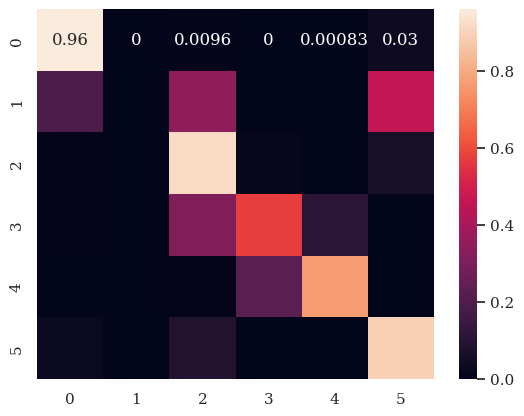

/tmp/ipykernel_423619/3885554587.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt


###### PHASE 2 FINISHED ########OUTPUT_FOLDER##


	  - Target loss: 0.0419, score: 0.8102: 100%|██| 76/76 [00:02<00:00, 32.33it/s]


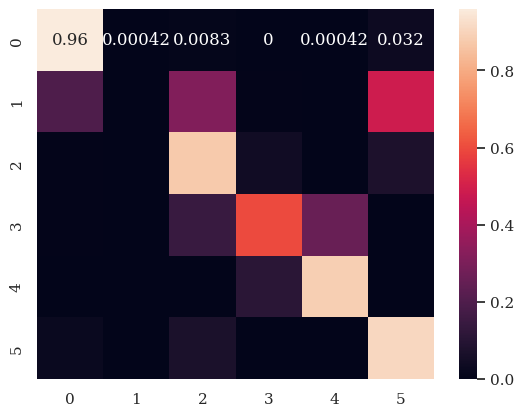

/tmp/ipykernel_423619/3885554587.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt


###### PHASE 3 FINISHED ##########


	  - Target loss: 0.0323, score: 0.8523: 100%|██| 76/76 [00:01<00:00, 46.26it/s]


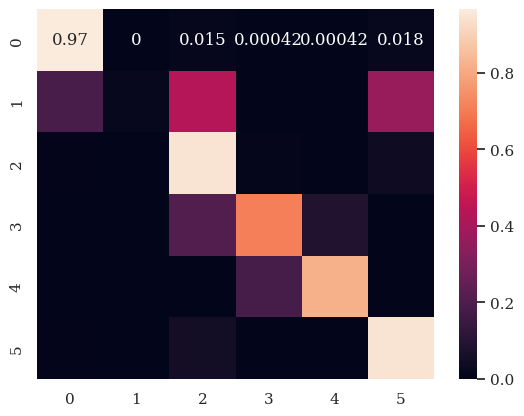

/tmp/ipykernel_423619/3885554587.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt

Training completed in: 00h 42m 01s


	  - Target loss: 0.0323, score: 0.8523: 100%|██| 76/76 [00:02<00:00, 33.50it/s]


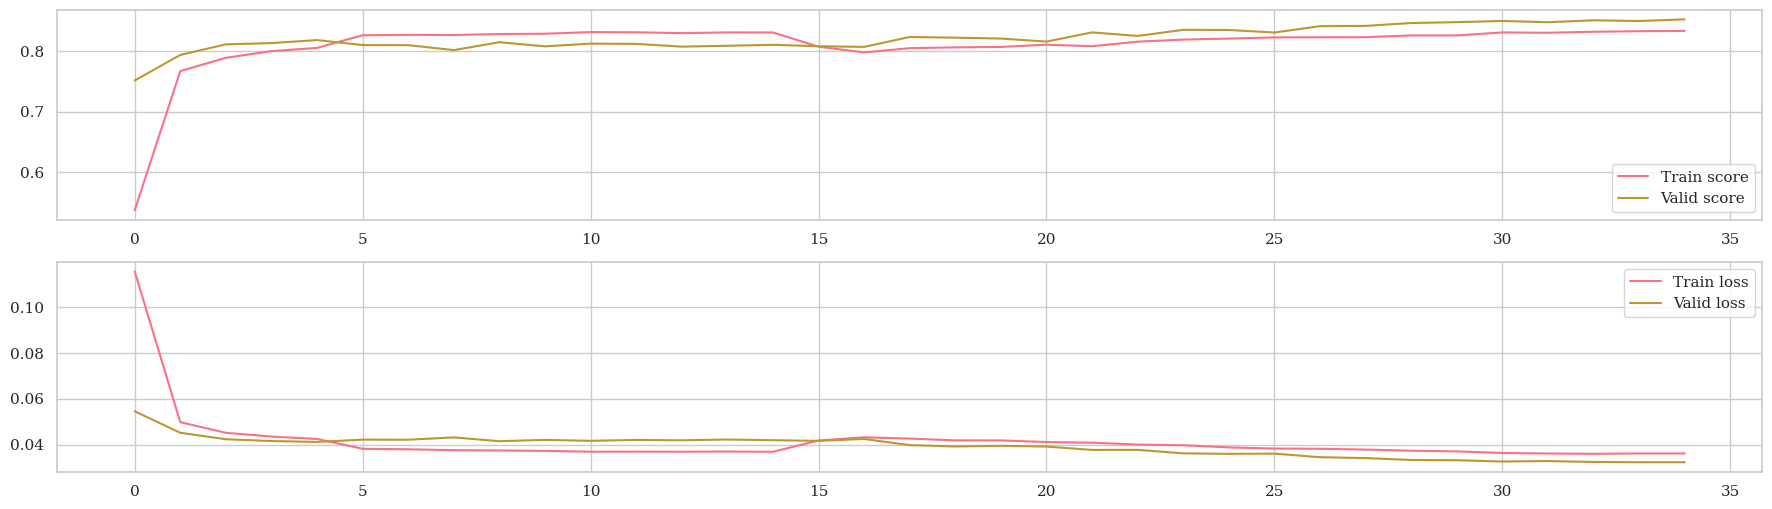

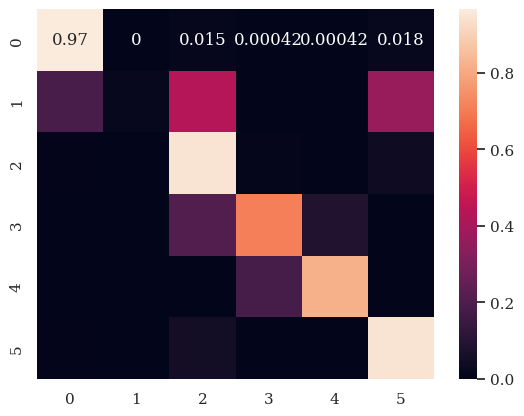

/tmp/ipykernel_423619/3885554587.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt

TypeError: calculate_test_accuracy() missing 1 required positional argument: 'true_labels'

In [27]:
args_array = []
args = base_args("eeg-classifier_seed-42")
seed_everything(args.seed)
model = EEGClassifier()

# Call the new function that tracks time and saves the model
run_and_save_model(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=None, supervised_mixup_data=supervised_mixup_data)

args_array.append(args)
